In [39]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from scipy.stats import shapiro, ttest_ind, f_oneway
import warnings 
warnings.filterwarnings("ignore")

In [40]:
pio.templates.default = "plotly_white"

In [41]:
stocks_data = pd.read_csv(r"C:\Users\ADITYA UPADHYAY\Downloads\stocks.csv")
stocks_data.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [42]:
descriptive_stats = stocks_data.groupby('Ticker')["Close"].describe()
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,62.0,158.240645,7.360485,145.309998,152.077499,158.055000,165.162506,173.570007
GOOG,62.0,100.631532,6.279464,89.349998,94.702501,102.759998,105.962503,109.459999
MSFT,62.0,275.039839,17.676231,246.270004,258.742500,275.810013,287.217506,310.649994
NFLX,62.0,327.614677,18.554419,292.760010,315.672493,325.600006,338.899994,366.829987


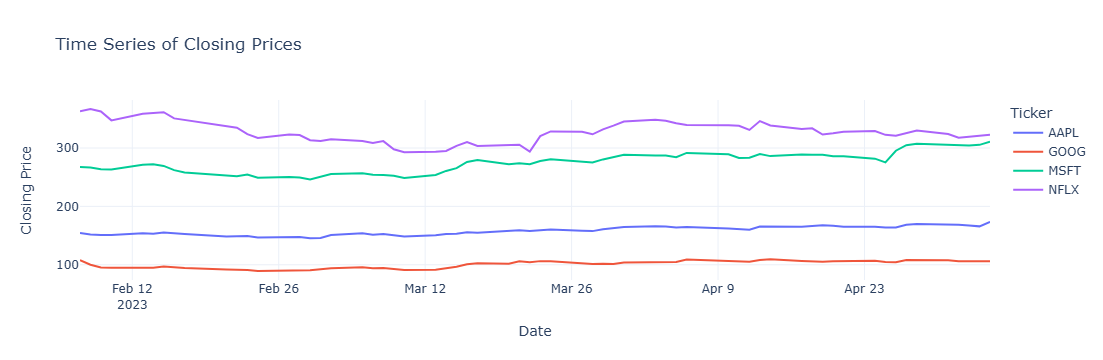

In [43]:
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])
pivot_data = stocks_data.pivot(index='Date', columns='Ticker', values='Close')

fig = make_subplots(rows=1, cols=1)
for column in pivot_data.columns:
    fig.add_trace(
        go.Scatter(x=pivot_data.index, y=pivot_data[column], name=column),
        row=1, col=1
    )
fig.update_layout(
    title_text='Time Series of Closing Prices',
    xaxis_title='Date',
    yaxis_title='Closing Price',
    legend_title='Ticker',
    showlegend=True
)
fig.show()

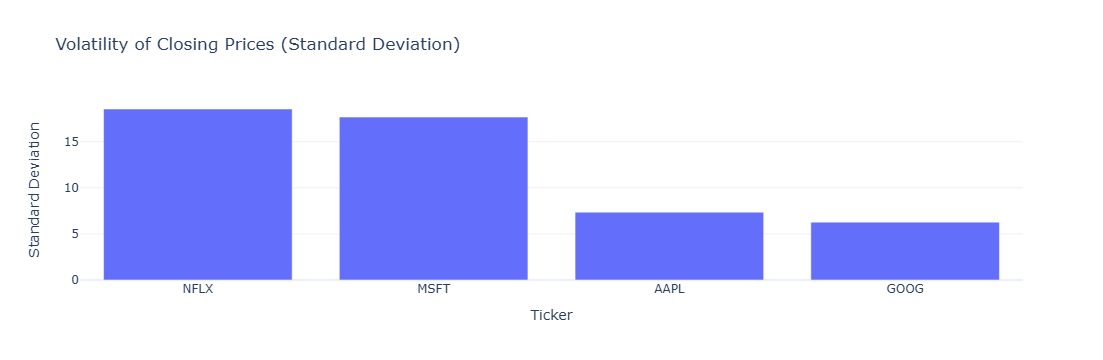

In [44]:
volatility = pivot_data.std().sort_values(ascending=False)
fig = px.bar(volatility,
             x=volatility.index,
             y=volatility.values,
             labels={'y': 'Standard Deviation', 'x': 'Ticker'},
             title='Volatility of Closing Prices (Standard Deviation)')
fig.show()

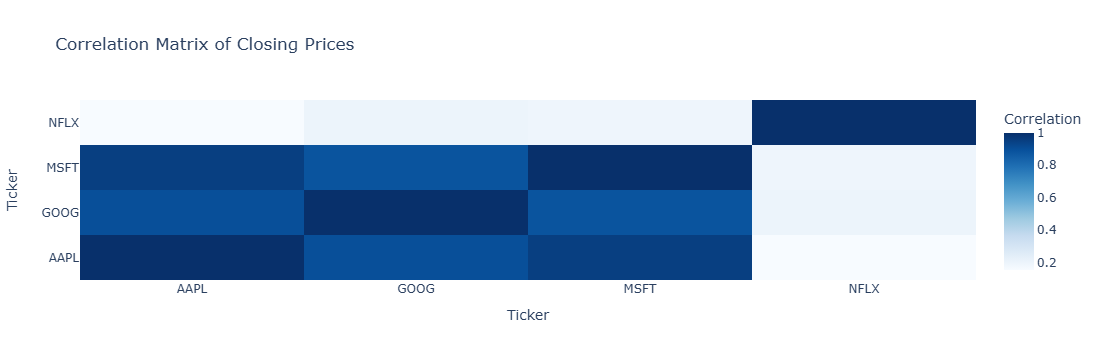

In [45]:
correlation_matrix = pivot_data.corr()
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='Blues',
    colorbar=dict(title='Correlation'),
))
fig.update_layout(
    title='Correlation Matrix of Closing Prices',
    xaxis_title='Ticker',
    yaxis_title='Ticker'
)
fig.show()

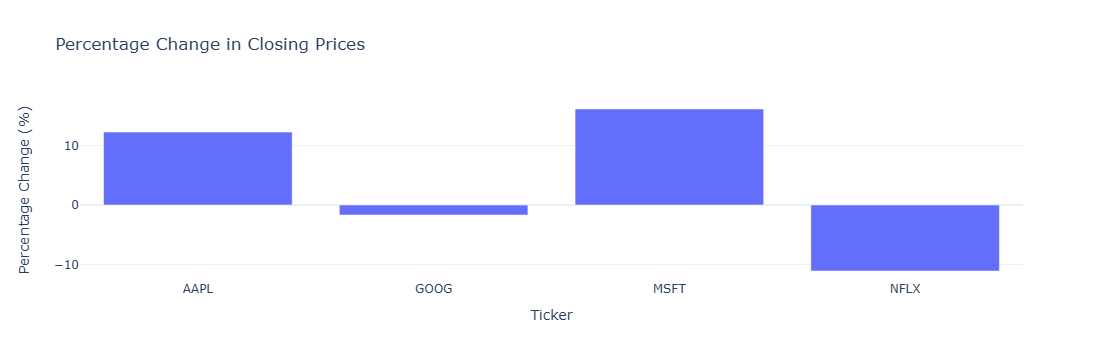

In [46]:
percentage_change = ((pivot_data.iloc[-1] - pivot_data.iloc[0]) / pivot_data.iloc[0]) * 100
fig = px.bar(percentage_change,
             x=percentage_change.index,
             y=percentage_change.values,
             labels={'y': 'Percentage Change (%)', 'x': 'Ticker'},
             title='Percentage Change in Closing Prices')
fig.show()

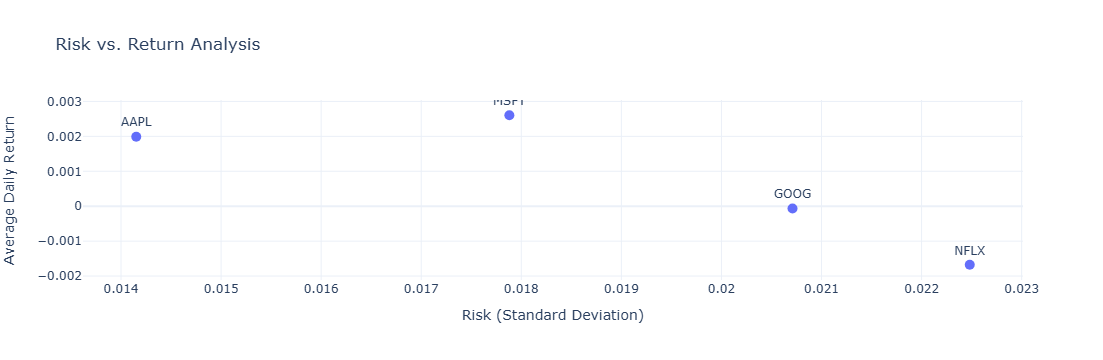

In [47]:
daily_returns = pivot_data.pct_change().dropna()
avg_daily_return = daily_returns.mean()
risk = daily_returns.std()

risk_return_df = pd.DataFrame({'Risk': risk, 'Average Daily Return': avg_daily_return})

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=risk_return_df['Risk'],
    y=risk_return_df['Average Daily Return'],
    mode='markers+text',
    text=risk_return_df.index,
    textposition="top center",
    marker=dict(size=10)
))
fig.update_layout(
    title='Risk vs. Return Analysis',
    xaxis_title='Risk (Standard Deviation)',
    yaxis_title='Average Daily Return',
    showlegend=False
)
fig.show()

In [48]:
risk_free_rate = 0.01
sharpe_ratios = (avg_daily_return - risk_free_rate / 252) / risk
market_data = stocks_data[stocks_data['Ticker'] == 'AAPL']['Close'].pct_change().dropna()
common_dates = daily_returns.index.intersection(market_data.index)
aligned_market_data = market_data.loc[common_dates]
aligned_daily_returns = daily_returns.loc[common_dates]
market_return = aligned_market_data.mean()
market_volatility = aligned_market_data.std()
betas = {}
for stock in aligned_daily_returns.columns:
    stock_return = aligned_daily_returns[stock]
    covariance_matrix = np.cov(stock_return, aligned_market_data)
    covariance = covariance_matrix[0, 1]
    beta = covariance / (market_volatility ** 2)
    betas[stock] = beta
betas
# CAGR Calculation
total_years = (pivot_data.index[-1] - pivot_data.index[0]).days / 365.25
cagr = (pivot_data.iloc[-1] / pivot_data.iloc[0]) ** (1 / total_years) - 1
cagr

Ticker
AAPL    0.623445
GOOG   -0.069025
MSFT    0.871798
NFLX   -0.389021
dtype: float64

In [49]:
# Hypothesis Testing
# Normality test
normality_results = {}
for ticker in pivot_data.columns:
    stat, p_value = shapiro(pivot_data[ticker].dropna())
    normality_results[ticker] = (stat, p_value)

normality_results

# ANOVA test for differences in means
anova_result = f_oneway(*(pivot_data[ticker].dropna() for ticker in pivot_data.columns))
anova_result

# T-test between two stocks
t_stat, t_p_value = ttest_ind(pivot_data['AAPL'].dropna(), pivot_data['GOOG'].dropna())
(t_stat, t_p_value)

(46.88453262715365, 6.930552137380044e-80)

In [50]:
# Summary of Results
summary = {
    "Sharpe Ratios": sharpe_ratios,
    "Betas": betas,
    "CAGR": cagr,
    "Normality Test Results": normality_results,
    "ANOVA Result": anova_result,
    "T-test Result": (t_stat, t_p_value)
}

summary

{'Sharpe Ratios': Ticker
 AAPL    0.137916
 GOOG   -0.005142
 MSFT    0.143517
 NFLX   -0.076333
 dtype: float64,
 'Betas': {'AAPL': nan, 'GOOG': nan, 'MSFT': nan, 'NFLX': nan},
 'CAGR': Ticker
 AAPL    0.623445
 GOOG   -0.069025
 MSFT    0.871798
 NFLX   -0.389021
 dtype: float64,
 'Normality Test Results': {'AAPL': (0.9524995684623718, 0.017633909359574318),
  'GOOG': (0.8860054016113281, 3.224261672585271e-05),
  'MSFT': (0.9538373947143555, 0.020497938618063927),
  'NFLX': (0.9797065258026123, 0.3940810561180115)},
 'ANOVA Result': F_onewayResult(statistic=3590.374591283376, pvalue=1.7021441149914017e-201),
 'T-test Result': (46.88453262715365, 6.930552137380044e-80)}